In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version= 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [8]:
X, y = mnist['data'], mnist['target']

In [9]:
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

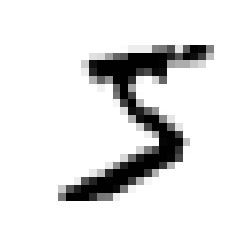

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [12]:
y[0]

'5'

In [13]:
# As seen above, the labels are strings and we prefere numbers, we will cast y to integers:
import numpy as np
y = y.astype(np.uint8)

In [14]:
# We should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually
# already split into a training set (the first 60.000 images) and a test set (the last 10.000 images):

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier
Let's simplify the problem for now and only try to identify one digit - for example the number 5. This "5-detector" will be capable of distinguish between just two classes, 5 and not-5.

In [15]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [16]:
# Let's pick a classifier and train it. A good place to start is with a Stochastic Gradient escent (SGD) classifier, using
# Scikit-Learn's SGDClassifier class.
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([False])

### Measuring Accuracy Using Cross-Validation

In [18]:
# ImplementingCross-Validation
# The following code does roughly the same thing as Scikit-Learn's cross_val_score() funtion, and prints the same result

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

# The StratifiedKFold class performs stratified sampling to produce folds that contain a representaive ratio of each class.
# At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions
# on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

0.9532
0.95125
0.9625


##### Let's use `cross_val_score()` funtion to evaluate the SGDClassifier model

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv= 3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

### Confusion Matrix
The idea of a **Confusion Matrix** is to count the number of times instances of class A are classified as class B. For example, to know te number of timesthe classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

In [20]:
# To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actua targets.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the _negative class_): 52.992 of them were correctly classified as non-5s (they are called _true negatives_), while the remaining 1.587 were wrongly classified as 5s (_false positives_). The second row considers the images of 5s (the _positive class_): 1074 were wrongly classified as non-5s (_false negative_), while the remaining 4347 were correctly classified as 5s (_true positives_). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal.

In [22]:
y_train_perfect_predictions = y_train_5 # pretend we reaced perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called _precision_ of the classifier

$precision = \frac{TP}{TP + FP}$

TP is the number of true positives, and FP is the number of false positives.

Precision is typically used along with another metric named _recall_, also called _sensitivity_ or _true positive rate_ (TPR): this is the ratio of positive instances that are correctly detected by the classifier

$recall = \frac{TP}{TP + FN}$

FN is the number of false negatives.

![An illustrated confusion matrix](https://bbsmax.ikafan.com/static/L3Byb3h5L2h0dHBzL2ltZzIwMTguY25ibG9ncy5jb20vYmxvZy8xMDEyNTkwLzIwMTkwMy8xMDEyNTkwLTIwMTkwMzI3MDkxOTExMTMzLTc5MzYxMjk5NS5wbmc=.jpg)

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4347/(4347 + 1587)

0.7325581395348837

In [24]:
recall_score(y_train_5, y_train_pred) # == 4347/(4347 + 1074)

0.8018815716657444

It is often convenient to combine precision and recall into a single metric called the _F<sub>1</sub> score_, in particular if you need a simple way to compare two classifiers. The F<sub>1</sub> score is the _harmonic mean_ of pecision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F<sub>1</sub> score if both recall and precision are high.

$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}= 2 x \frac{precision x recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

### Precision/Recall Tradeoff

In [26]:
# This will return all the score values given by the sgd_clf classifier to each X_train instances
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3, method= 'decision_function')

# Now with these scores we can compute precision and recall for all possible threshokds using the precision_recall_curve() 
# function

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

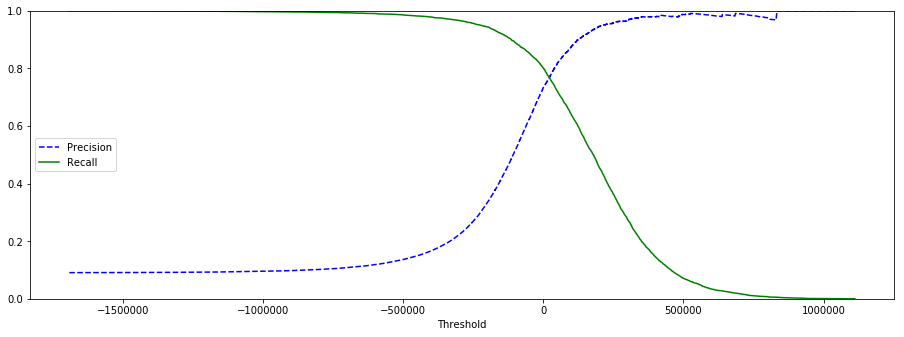

In [28]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(thresholds, precision[:-1],"b--", label= 'Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label= 'Recall')
    ax.set_xlabel('Threshold')
    ax.legend(loc='center left')
    ax.set_ylim([0, 1])
    
plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

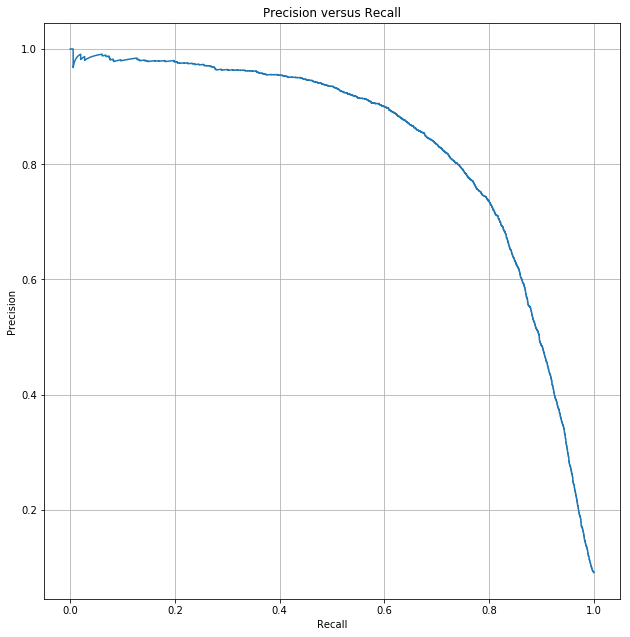

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])

ax.plot(recalls, precision)
ax.set_title('Precision versus Recall')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()

plt.show()

### The ROC Curve
The _receiver operating characteristic_ (ROC) curve is anorher common tool used with binary classifiers. Itplots the _true positive rate_ (another name for recall) against the _false positive rate_. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the _true negative rate_, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called _specificity_. Hence the ROC curve plots _sensitivity_ (recall) versus 1 - _specificity_.

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(*args, **kw)>

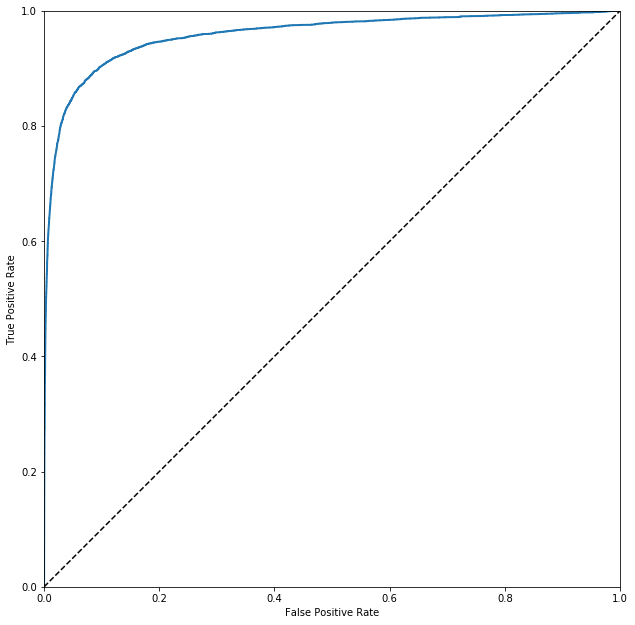

In [31]:
def plot_roc_curve(fpr, tpr, label= None):
    fig = plt.figure(figsize= (8, 8))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(fpr, tpr, linewidth= 2, label= label)
    ax.plot([0, 1],[0, 1], 'k--')
    ax.axis([0, 1, 0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show

One way to compare classifiers is to easyre the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0,5. Scikit-Learn provides a function to compute the ROC AUC:

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

### Using Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state= 42, n_estimators= 10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv= 3, method='predict_proba')

In [34]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

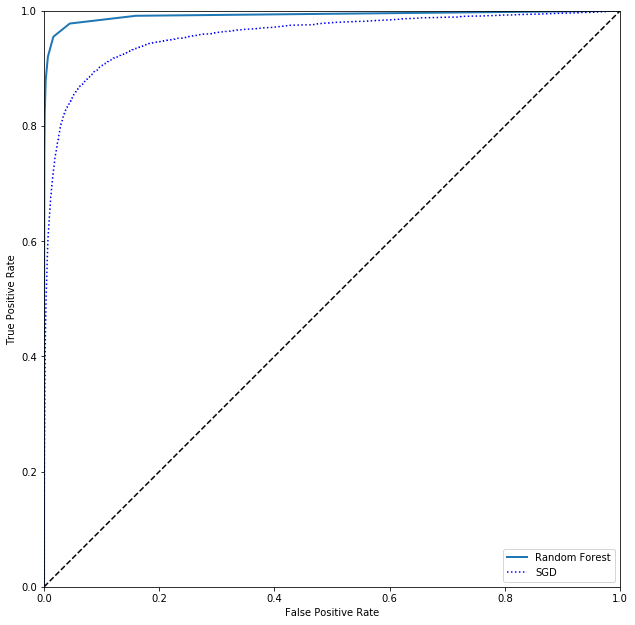

In [35]:
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot(fpr, tpr, 'b:', label="SGD")
plt.legend(loc='lower right')
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [37]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv= 3)
precision_score(y_train_5, y_train_pred_forest)

0.986046511627907

In [38]:
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889

In [39]:
precision, recalls, thresholds = precision_recall_curve(y_train_5, y_train_pred_forest)

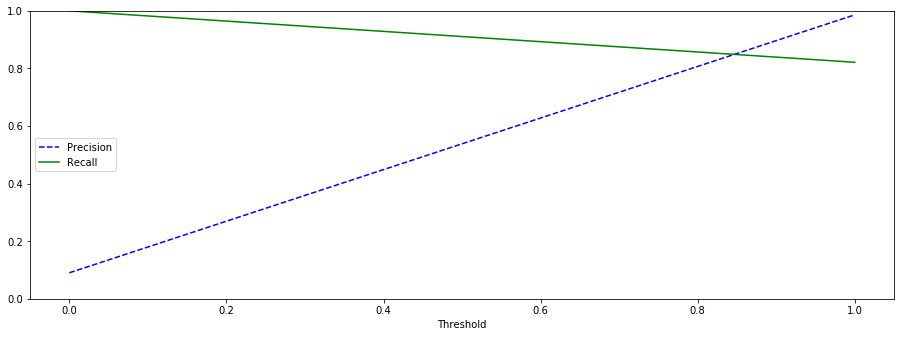

In [40]:
plot_precision_recall_vs_threshold(precision, recalls, thresholds)

### Multiclass Classification

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that this is indeed the case, you can call the `decision_function()` method. Insted of returning just one score per instance, it now returns 10 scores, one per class:

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-433195.51807197, -338154.39320296, -233775.78280018,
         -96549.33208399, -775699.13613034,  -45148.19955869,
        -536304.97603686, -298210.05377635, -535633.57179218,
        -490653.60782097]])

In [43]:
np.argmax(some_digit_scores)

5

In [44]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If we want to force ScikitLearn to use one-versus-one or one-versus-all, we can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a binary classifier to its constructor.

In [45]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
len(ovo_clf.estimators_)

45

In [47]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not gave to run Ova or OvO because Random Forest classifiers can directly classify instances into multiple classes. We can call `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [48]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

We can see that the classifier is fairly confident about its prediction: the 0.8 at the 5<sup>th</sup> index in the array means that the model estimates an 80% probability that the image represents a 5. It also thinks that the image could instead be a 3 (20% chance)

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv= 3, scoring='accuracy')

array([0.86872625, 0.87639382, 0.87848177])

It gets over 86% on all test folds. If we used a random classifier, we would get 10% accuracy, so this is not such a bad score, but we can still do much better. For example, simply scaling the inputs increases accuracy above 90%:

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv= 3, scoring= 'accuracy')

array([0.90736853, 0.90884544, 0.91363705])

### Error Analysis

Here, we will assume that we found a promising model and we want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, we can look at the confusion matrix. We need to make predictions unsing the `cross_val_predict()` function, then call the `confusion_matrix()` function, just like we did earlier:

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv= 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5726,    2,   26,   12,   11,   47,   47,    9,   39,    4],
       [   1, 6479,   42,   33,    8,   39,    8,    9,  113,   10],
       [  55,   35, 5319,  104,   79,   20,  106,   51,  174,   15],
       [  45,   40,  145, 5372,    3,  210,   33,   50,  135,   98],
       [  17,   26,   38,    8, 5361,    5,   57,   31,   86,  213],
       [  74,   38,   43,  199,   71, 4584,  116,   26,  175,   95],
       [  33,   22,   43,    2,   42,   90, 5640,    3,   43,    0],
       [  24,   23,   73,   29,   60,   12,    4, 5774,   18,  248],
       [  49,  165,   73,  150,   16,  153,   50,   24, 5038,  133],
       [  39,   31,   26,   92,  163,   35,    3,  177,   79, 5304]],
      dtype=int64)

That's a lot of numbers, It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's `matshow()` function:

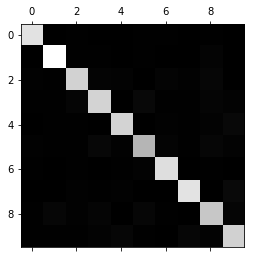

In [52]:
plt.matshow(conf_mx, cmap= plt.cm.gray)
plt.show()

Let's focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute number of errors:

In [53]:
row_sums = conf_mx.sum(axis= 1, keepdims= True)
norm_conf_mx= conf_mx / row_sums

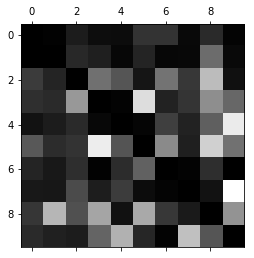

In [54]:
# Now let's fill the diagonal with zeros to keep only the errors, and let's plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()

### Multilabel Classification
Until now wach instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Such a classification system that outputs multiple binary labels is called a _multilabel classification_ system

In [55]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

This code creates a `y_multilabel` array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8 or 9) and the second indicates whether or not it is odd. The next lines create a `KNeighborsClassifier` instance (which supports multilabel classification, but not all classifiers do) and we train it using the multiple target array. Now we can make a prediction, and notice that i outputs two labels:

In [56]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv= 3)
#f1_score(y_multilabel, y_train_knn_pred, average='macro')

### Multioutput Classification